In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
! pip3 install transformers


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-24-3caa50c0ebbb>:48: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_df['reviewText'] = reviews_df['reviewText'].str.replace('[^\w\s]', '')


Average sentiment (TextBlob): 0.36568366541570246
Average sentiment (VADER): 0.6346318276712849


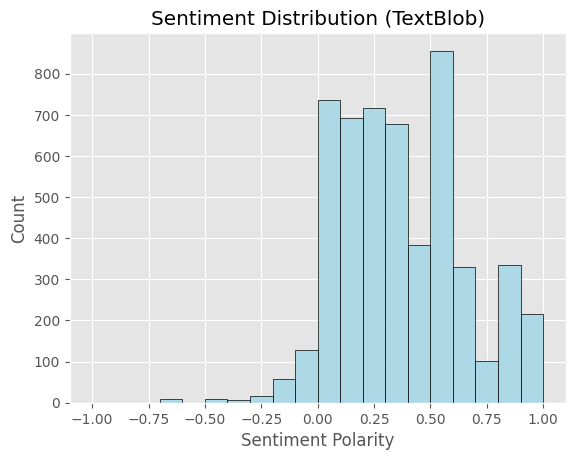

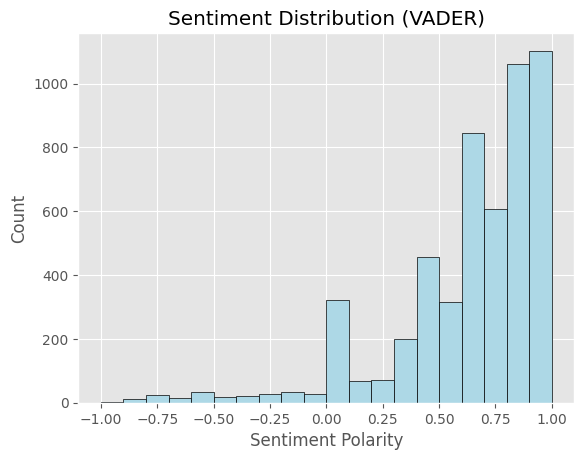

In [24]:
import pandas as pd
import json
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
import ssl

# Disable SSL certificate verification (not recommended for production use)
ssl._create_default_https_context = ssl._create_unverified_context

# Download the VADER lexicon data
nltk.download('vader_lexicon')

# Load review data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

# Sentiment analysis using TextBlob
def analyze_sentiment_textblob(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return 0.0

# Sentiment analysis using VADER (NLTK)
def analyze_sentiment_vader(text):
    if isinstance(text, str):
        sid = SentimentIntensityAnalyzer()
        sentiment_scores = sid.polarity_scores(text)
        return sentiment_scores['compound']
    else:
        return 0.0

# Load data
reviews_data = load_data('All_Beauty_5.json')

# Convert data to Pandas DataFrame
reviews_df = pd.DataFrame(reviews_data)

# Preprocess review text
reviews_df['reviewText'] = reviews_df['reviewText'].str.lower()
reviews_df['reviewText'] = reviews_df['reviewText'].str.replace('[^\w\s]', '')

# Analyze sentiment using TextBlob and VADER
reviews_df['sentiment_textblob'] = reviews_df['reviewText'].apply(analyze_sentiment_textblob)
reviews_df['sentiment_vader'] = reviews_df['reviewText'].apply(analyze_sentiment_vader)

# Analyze sentiment distribution
average_sentiment_textblob = reviews_df['sentiment_textblob'].mean()
average_sentiment_vader = reviews_df['sentiment_vader'].mean()

print(f'Average sentiment (TextBlob): {average_sentiment_textblob}')
print(f'Average sentiment (VADER): {average_sentiment_vader}')

# Identify positive and negative reviews
positive_reviews_textblob = reviews_df[reviews_df['sentiment_textblob'] > 0]
negative_reviews_textblob = reviews_df[reviews_df['sentiment_textblob'] < 0]

positive_reviews_vader = reviews_df[reviews_df['sentiment_vader'] > 0]
negative_reviews_vader = reviews_df[reviews_df['sentiment_vader'] < 0]

# Visualize sentiment distribution
plt.hist(reviews_df['sentiment_textblob'], bins=20, range=(-1, 1), color='lightblue', edgecolor='black')
plt.title('Sentiment Distribution (TextBlob)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.show()

plt.hist(reviews_df['sentiment_vader'], bins=20, range=(-1, 1), color='lightblue', edgecolor='black')
plt.title('Sentiment Distribution (VADER)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.show()


In [25]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'


In [26]:
reviews_df = pd.DataFrame(reviews_data)

reviews_df.insert(0, 'Id', range(1, len(reviews_df) + 1))

# Display the updated DataFrame


# Display the shape and the first few rows of the DataFrame
print(reviews_df.shape)
print(reviews_df.head())

(5269, 13)
   Id  overall  verified   reviewTime      reviewerID        asin  \
0   1      5.0      True   09 1, 2016  A3CIUOJXQ5VDQ2  B0000530HU   
1   2      5.0      True  11 14, 2013  A3H7T87S984REU  B0000530HU   
2   3      1.0      True  08 18, 2013  A3J034YH7UG4KT  B0000530HU   
3   4      5.0     False   05 3, 2011  A2UEO5XR3598GI  B0000530HU   
4   5      5.0      True   05 6, 2011  A3SFRT223XXWF7  B00006L9LC   

                                               style     reviewerName  \
0  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...         Shelly F   
1  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...     houserules18   
2  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...             Adam   
3  {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...           Rich K   
4                          {'Size:': ' 200ml/6.7oz'}  C. C. Christian   

                                          reviewText  \
0                   As advertised. Reasonably priced   
1  Like the oder and th

In [27]:
reviews_df['overall'].unique()

array([5., 1., 2., 4., 3.])

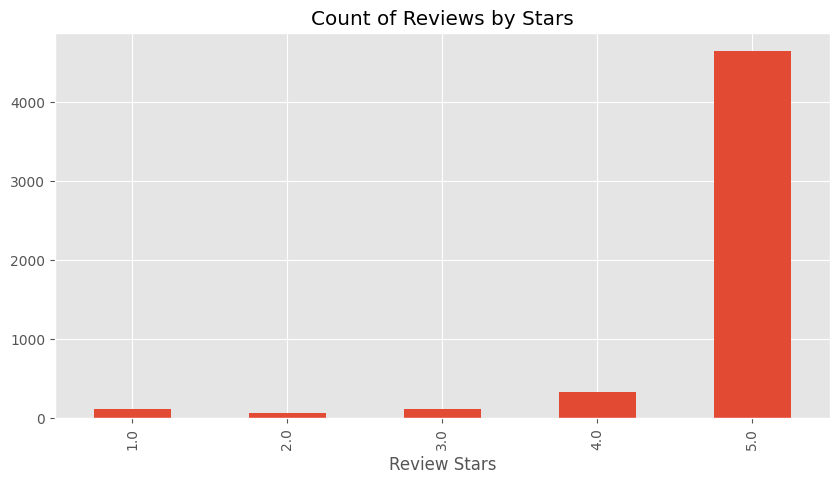

In [28]:
ax = reviews_df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [29]:
example = reviews_df['reviewText'][50]
print(example)

Nope. It smells like artificial bananas, and this smell does linger. It's pure liquid, there is no thickness to it at all, it's like pouring banana water on your head that lathers. It does not help with an itchy scalp either (I have psoriasis). This shampoo neither helped nor hindered my hair or scalp, made absolutely no difference (except for the banana smell). Don't waste your money.


In [30]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Nope',
 '.',
 'It',
 'smells',
 'like',
 'artificial',
 'bananas',
 ',',
 'and',
 'this']

In [31]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Nope', 'NN'),
 ('.', '.'),
 ('It', 'PRP'),
 ('smells', 'VBZ'),
 ('like', 'IN'),
 ('artificial', 'JJ'),
 ('bananas', 'NNS'),
 (',', ','),
 ('and', 'CC'),
 ('this', 'DT')]

In [32]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Nope/NN)
  ./.
  It/PRP
  smells/VBZ
  like/IN
  artificial/JJ
  bananas/NNS
  ,/,
  and/CC
  this/DT
  smell/NN
  does/VBZ
  linger/JJR
  ./.
  It/PRP
  's/VBZ
  pure/JJ
  liquid/NN
  ,/,
  there/EX
  is/VBZ
  no/DT
  thickness/NN
  to/TO
  it/PRP
  at/IN
  all/DT
  ,/,
  it/PRP
  's/VBZ
  like/IN
  pouring/VBG
  banana/JJ
  water/NN
  on/IN
  your/PRP$
  head/NN
  that/IN
  lathers/NNS
  ./.
  It/PRP
  does/VBZ
  not/RB
  help/VB
  with/IN
  an/DT
  itchy/NN
  scalp/NN
  either/CC
  (/(
  I/PRP
  have/VBP
  psoriasis/VBN
  )/)
  ./.
  This/DT
  shampoo/NN
  neither/DT
  helped/VBD
  nor/CC
  hindered/JJ
  my/PRP$
  hair/NN
  or/CC
  scalp/NN
  ,/,
  made/VBD
  absolutely/RB
  no/DT
  difference/NN
  (/(
  except/IN
  for/IN
  the/DT
  banana/NN
  smell/NN
  )/)
  ./.
  Do/VBP
  n't/RB
  waste/VB
  your/PRP$
  money/NN
  ./.)


In [33]:
# VADER
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [34]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [35]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [36]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [37]:
sia.polarity_scores(example)

{'neg': 0.172, 'neu': 0.797, 'pos': 0.031, 'compound': -0.8246}

In [38]:
! pip3 install --upgrade jupyter ipywidgets
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"




In [40]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

# Assuming your DataFrame is named 'df'
reviews_df['reviewText'] = reviews_df['reviewText'].fillna('')  # Replace NaN values with empty strings

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Create an empty dictionary to store the results
res = {}

# Loop through the DataFrame
for i, row in tqdm(reviews_df.iterrows(), total=len(reviews_df)):
    text = str(row['reviewText'])  # Convert the text to a string
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

# 'res' will contain sentiment scores for each 'Id'


100%|██████████| 5269/5269 [00:08<00:00, 649.35it/s]


In [41]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
# Specify the common column to merge on
vaders = vaders.merge(reviews_df, on='Id', how='left')


In [42]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,1,0.000,1.000,0.000,0.0000,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,2,0.000,0.896,0.104,0.3434,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,3,0.106,0.707,0.187,0.3182,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,4,0.072,0.839,0.088,0.8158,5.0,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,0.000,0.828,0.172,0.7088,5.0,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


In [43]:
lowest_vader_score = vaders['compound'].min()
print(f"Lowest VADER 'compound' score: {lowest_vader_score}")


Lowest VADER 'compound' score: -0.9871


Text(0.5, 1.0, 'Compund Score by Amazon Star Review')

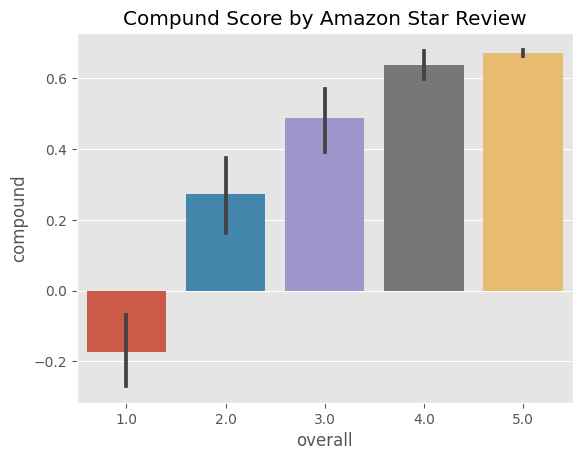

In [44]:
ax = sns.barplot(data=vaders, x='overall', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

<Axes: xlabel='overall', ylabel='pos'>

<Axes: xlabel='overall', ylabel='neu'>

<Axes: xlabel='overall', ylabel='neg'>

Text(0.5, 1.0, 'Positive')

Text(0.5, 1.0, 'Neutral')

Text(0.5, 1.0, 'Negative')

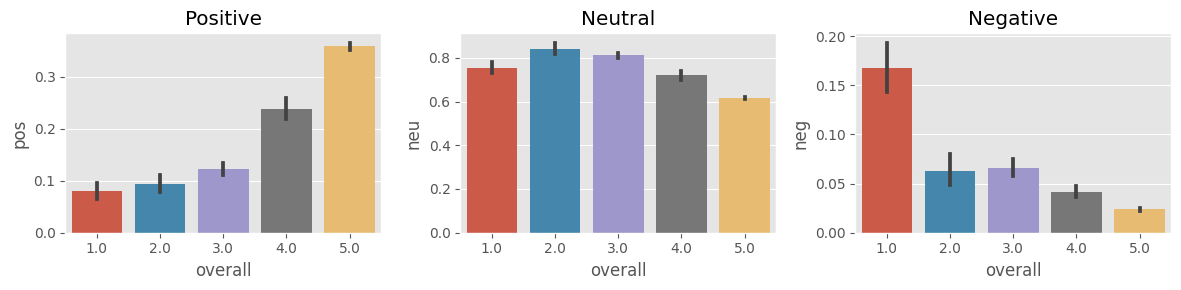

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [46]:
import pandas as pd
import tqdm

In [47]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
from scipy.special import softmax


In [5]:
# RoBERTa tokenizer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [6]:
# Run for Roberta Model
example = "This is a sample text for sentiment analysis using RoBERTa."

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.024569483, 'roberta_neu': 0.9146819, 'roberta_pos': 0.06074872}


In [51]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [52]:
from tqdm import tqdm

In [53]:
res = {}
for i, row in tqdm(reviews_df.iterrows(), total=len(reviews_df)):
    try:
        text = row['reviewText']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

 24%|██▍       | 1277/5269 [05:00<46:56,  1.42it/s]  

Broke for id 1277


 89%|████████▉ | 4698/5269 [18:03<05:34,  1.71it/s]

Broke for id 4699


 90%|████████▉ | 4739/5269 [18:33<08:23,  1.05it/s]

Broke for id 4740


 90%|█████████ | 4744/5269 [18:39<11:09,  1.27s/it]

Broke for id 4745


 92%|█████████▏| 4845/5269 [19:33<02:41,  2.63it/s]

Broke for id 4846
Broke for id 4847


 92%|█████████▏| 4861/5269 [19:41<04:13,  1.61it/s]

Broke for id 4862


 93%|█████████▎| 4925/5269 [20:10<02:02,  2.82it/s]

Broke for id 4926
Broke for id 4927
Broke for id 4928
Broke for id 4929


 94%|█████████▎| 4930/5269 [20:11<00:54,  6.20it/s]

Broke for id 4931


 97%|█████████▋| 5085/5269 [21:17<03:16,  1.07s/it]

Broke for id 5086


100%|██████████| 5269/5269 [22:05<00:00,  3.98it/s]


In [54]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(reviews_df, how='left')

In [55]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'overall', 'verified',
       'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'vote', 'image'],
      dtype='object')

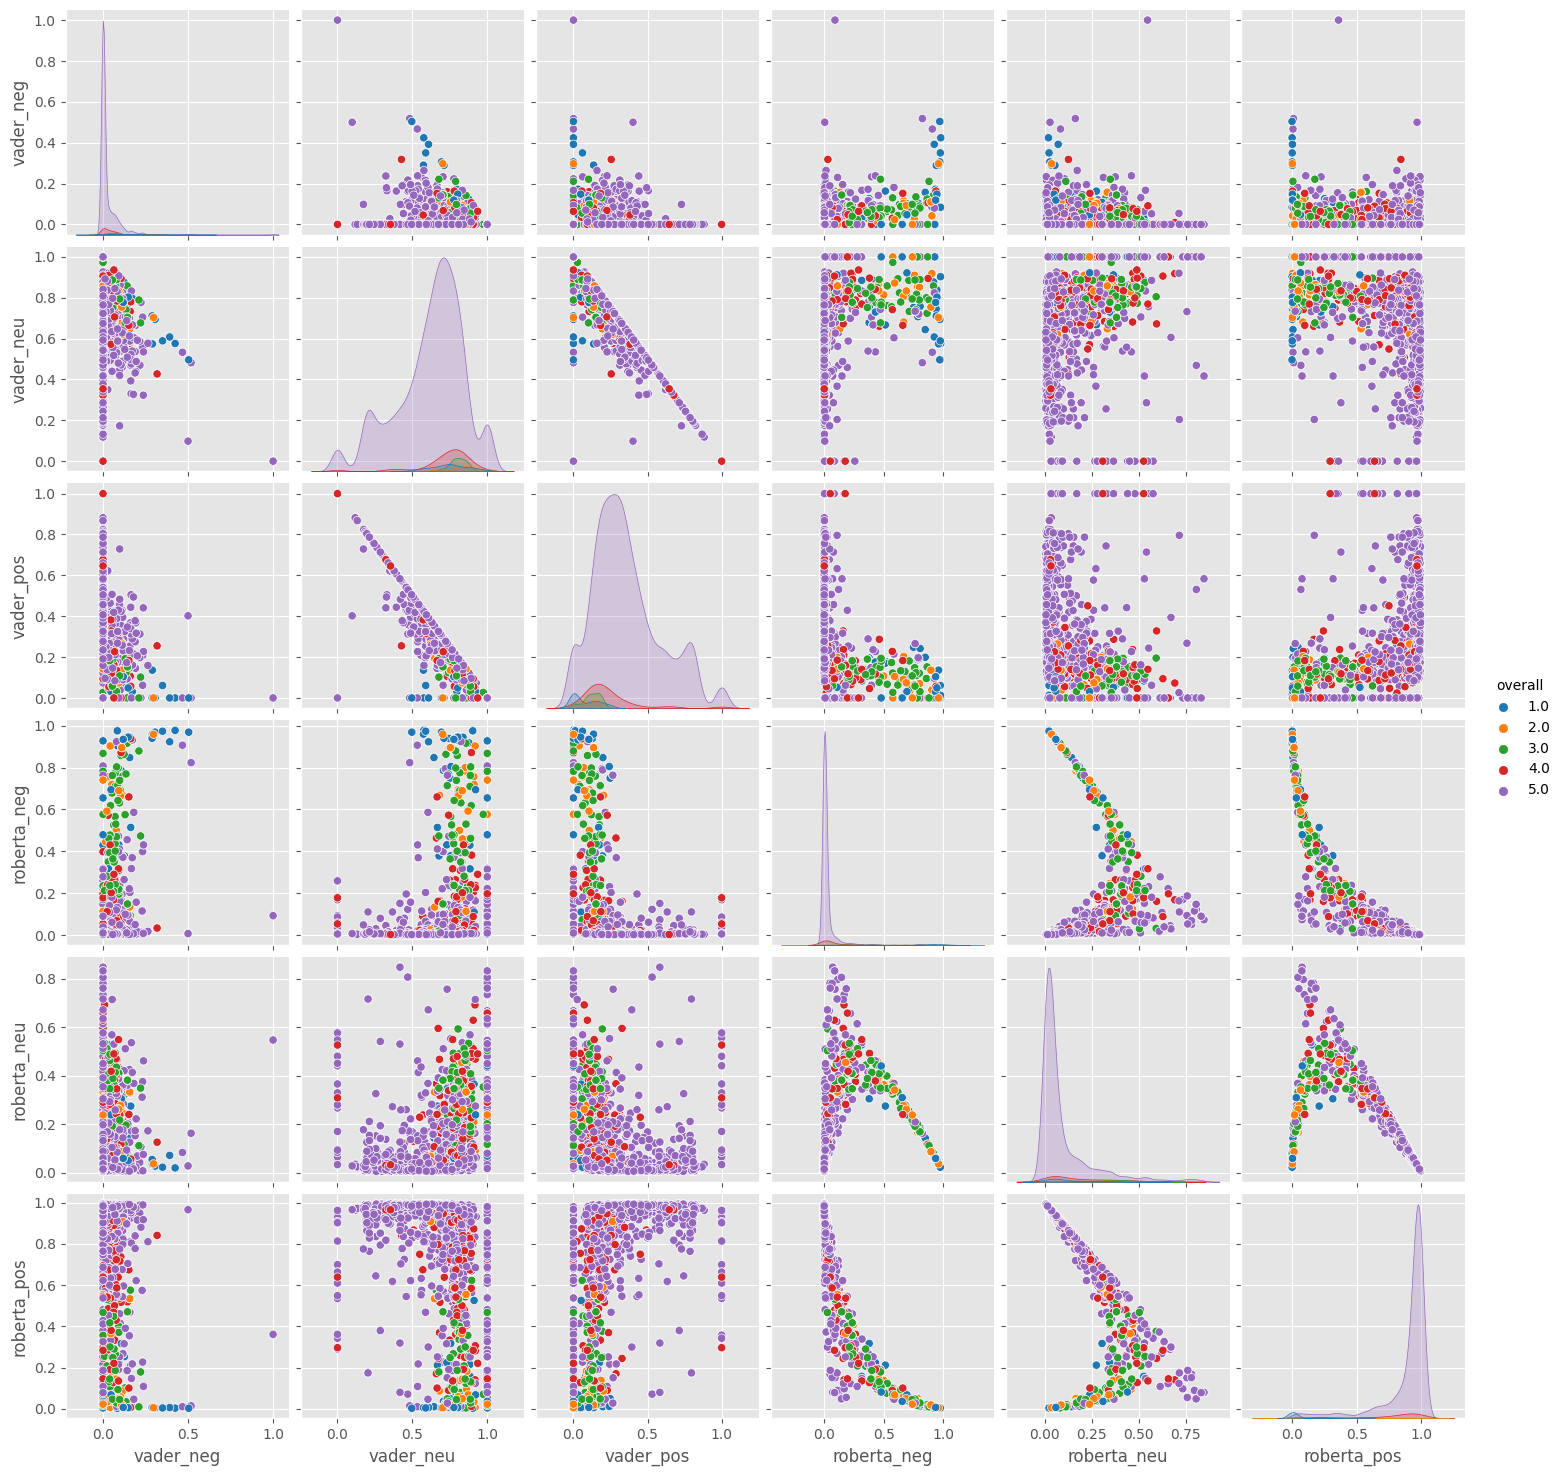

In [56]:
import seaborn as sns

sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='overall',
            palette='tab10')
plt.show()

In [57]:
results_df.query('overall == 1') \
    .sort_values('roberta_pos', ascending=False)['reviewText'].values[0]

"I used Jan Marini eyelash intervention and my lashes were longer and noticeable. I wanted to try something else and Revitalash had a good reviews. After 3 month of everyday use there's no difference at all! Now I'm gonna try Procyde MD Lash factor if that doesn't work I'm gonna be back to Jan Marini even it's the most expensive lash conditioner."

In [58]:
results_df.query('overall == 1') \
    .sort_values('vader_pos', ascending=False)['reviewText'].values[0]

'This really dries out my hair and makes it feel even thinner than it already is. The smell is nice, but consistency is pretty much water. I honestly think most of the reviews are false '

In [59]:
results_df.query('overall == 5') \
    .sort_values('roberta_neg', ascending=False)['reviewText'].values[0]

'AS awesome as this product is, it HAS been discontinued by the makers. The people selling this on here, including the shampoos and conditioners ARE price gouging you and who knows how OLD it is..  Very Sad'

In [60]:
results_df.query('overall == 5') \
    .sort_values('vader_neg', ascending=False)['reviewText'].values[0]

'No problems.'

In [61]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [62]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [63]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [64]:
from sklearn.metrics import accuracy_score

In [65]:
from sklearn.metrics import accuracy_score

# Scale VADER compound scores to the range 1 to 5
vader_actual_sentiment = reviews_df.loc[reviews_df['Id'].isin(vaders['Id']), 'overall']  # Use the 'overall' column for actual sentiment

# Scale VADER compound scores to the range 1 to 5
vader_predicted_ratings = 2 * vaders.loc[vaders['Id'].isin(reviews_df['Id']), 'compound'] + 3

# Round the scaled ratings to the nearest integer
vader_predicted_ratings = vader_predicted_ratings.round().astype(int)

vader_accuracy = accuracy_score(vader_actual_sentiment, vader_predicted_ratings)
print(f"VADER Accuracy (Continuous Range Mapping): {vader_accuracy}")


VADER Accuracy (Continuous Range Mapping): 0.48491174795976466


In [66]:
# Calculate Roberta compound and map it to a continuous range
roberta_actual_sentiment = reviews_df.loc[reviews_df['Id'].isin(res.keys()), 'overall']  # Use the 'overall' column for actual sentiment

roberta_predicted_ratings = (res[myid]['roberta_pos'] - res[myid]['roberta_neg']) / (res[myid]['roberta_neu']+res[myid]['roberta_pos'] + res[myid]['roberta_neg'])

# Scale the Roberta compound scores to the range 1 to 5
roberta_predicted_ratings = 2 * roberta_predicted_ratings + 3

# Round the scaled ratings to the nearest integer
roberta_predicted_ratings = roberta_predicted_ratings.round().astype(int)

# Calculate accuracy for Roberta
roberta_accuracy = np.mean(np.array(roberta_actual_sentiment) == roberta_predicted_ratings)
print(f"Roberta Accuracy (Continuous Range Mapping): {roberta_accuracy}")


Roberta Accuracy (Continuous Range Mapping): 0.06278538812785388
